<a href="https://colab.research.google.com/github/JakobWyatt/smart-wheelchair/blob/main/colab/TrainSegModels_HybridNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Install dependencies
!pip install -q torch==1.12.1 torchvision timm webcolors albumentations efficientnet-pytorch pretrainedmodels torchshow
!git clone https://github.com/datvuthanh/HybridNets
%cd HybridNets
!git reset d53d2eac03736bef2729d10e9e0b0b6500d8721d --hard
%cd ..
!git clone https://github.com/hustvl/YOLOP

fatal: destination path 'HybridNets' already exists and is not an empty directory.
/content/HybridNets
HEAD is now at d53d2ea Merge pull request #69 from datvuthanh/xoiga123-patch-1
/content
fatal: destination path 'YOLOP' already exists and is not an empty directory.


In [7]:
# Extract our datasets from google drive
!mkdir datasets
!unzip drive/MyDrive/Thesis/datasets/bdd100k/bdd100k_images_100k.zip -d datasets/
!unzip drive/MyDrive/Thesis/datasets/bdd100k/det_annotations.zip -d datasets/
!unzip drive/MyDrive/Thesis/datasets/bdd100k/da_seg_annotations.zip -d datasets/
!unzip drive/MyDrive/Thesis/datasets/bdd100k/ll_seg_annotations.zip -d datasets/
!unzip drive/MyDrive/Thesis/datasets/cityscapes/gtFine_trainvaltest.zip -d datasets/
!unzip -o drive/MyDrive/Thesis/datasets/cityscapes/leftImg8bit_trainvaltest.zip -d datasets/

Streaming output truncated to the last 5000 lines.
 extracting: datasets/leftImg8bit/train/jena/jena_000074_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000040_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000020_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000030_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000005_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000059_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000100_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000034_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000089_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000104_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000107_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/je

In [5]:
import torch
import sys
sys.path.insert(0, "./HybridNets")
from hybridnets.model import ModelWithLoss
from backbone import HybridNetsBackbone
import seaborn as sns
from hybridnets.dataset import BddDataset
from torchvision.datasets import Cityscapes
from utils.utils import Params
from utils.constants import BINARY_MODE
from torchvision import transforms
from datetime import datetime
import PIL
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from pprint import pprint
from pathlib import Path

In [6]:
# Make sure we are using a GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print(torch.cuda.get_device_properties(device))
    print(torch.cuda.memory_summary())

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  

In [8]:
# Load the pretrained model
model_pretrained = torch.hub.load('datvuthanh/hybridnets', 'hybridnets', pretrained=True, device=device)
model_pretrained.eval()

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/datvuthanh/hybridnets/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficien

  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Downloading: "https://github.com/datvuthanh/HybridNets/releases/download/v1.0/hybridnets.pth" to /root/.cache/torch/hub/checkpoints/hybridnets.pth


  0%|          | 0.00/52.2M [00:00<?, ?B/s]

HybridNetsBackbone(
  (bifpn): Sequential(
    (0): BiFPN(
      (conv6_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), groups=160, bias=False)
        )
        (pointwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(160, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
      (conv5_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), groups=160, bias=False)
        )
        (pointwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(160, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
      (conv4_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePaddi

In [25]:
# Define the location of our training and validatation data
# Standard transform - only needs to be tuned to each dataset for final performance metrics
params = Params('./HybridNets/projects/bdd100k.yml')
params.dataset['dataroot'] = "datasets/bdd100k/images/100k"
params.dataset['labelroot'] = "datasets/data2/zwt/bdd/bdd100k/labels/100k"
params.dataset['segroot'] = ["datasets/bdd_seg_gt", "datasets/bdd_lane_gt"]
dataset_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=params.mean, std=params.std
    )
])

In [10]:
# Create our own model without lane detection
# Freeze backbone and object detection
model = HybridNetsBackbone(num_classes=len(params.obj_list), compound_coef=3,
                               ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales),
                               seg_mode=BINARY_MODE, backbone_name=None)
weight_url = 'https://github.com/datvuthanh/HybridNets/releases/download/v1.0/hybridnets.pth'
state_dict = torch.hub.load_state_dict_from_url(weight_url, map_location=device)
# Changing size of model
del state_dict['segmentation_head.0.weight']
del state_dict['segmentation_head.0.bias']
model.load_state_dict(state_dict, strict=False)
model = model.to(device)
# Freeze
model.encoder.requires_grad_(False)
model.bifpn.requires_grad_(False)
model.regressor.requires_grad_(False)
model.classifier.requires_grad_(False)
model.anchors.requires_grad_(False)
model = ModelWithLoss(model)

In [26]:
# Load the BDD100K dataset
bdd_train_dataset = BddDataset(
    params=params,
    is_train=True,
    inputsize=params.model['image_size'],
    transform=dataset_transforms
)
bdd_test_dataset = BddDataset(
    params=params,
    is_train=False,
    inputsize=params.model['image_size'],
    transform=dataset_transforms
)
bdd_train_loader = DataLoader(bdd_train_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=BddDataset.collate_fn)
bdd_test_loader = DataLoader(bdd_test_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=BddDataset.collate_fn)

building database...


  0%|          | 0/70000 [00:00<?, ?it/s]

database build finish
building database...


  0%|          | 0/10000 [00:00<?, ?it/s]

database build finish


In [23]:
# Random functions to help throughout the rest of the code

# make segmentation pretty again
def colorfill_segmentation(seg):
    colors = np.array([[0, 0, 0], [0, 128, 0], [0, 0, 128]], dtype=np.uint8)
    seg_mask = seg.byte().cpu().numpy()
    seg_mask = PIL.Image.fromarray(seg_mask)
    seg_mask.putpalette(colors)
    seg_mask = seg_mask.convert("RGB")
    seg_mask = np.array(seg_mask, dtype=np.uint8)
    return seg_mask

# Measure IoU from our test set
def confusionMatrix(output, target):
    output = torch.where(output == 1, 1, 0) # just drivable area
    target = torch.where(target == 1, 1, 0)

    tp = (output * target).sum([1,2])
    fp = output.sum([1,2]) - tp
    fn = target.sum([1,2]) - tp
    tn = torch.prod(torch.tensor(target.shape)) - tp - fp - fn
    return tn, fp, fn, tp

# A 3x2 confusion matrix:
#           Prediction
# Actual    tn  fp
#           fnrd tprd (road)
#           fnsw tpsw (path)
def confusionMatrixCityscapes(output, target):
    output = torch.where(output == 1, 1, 0) # just drivable area
    target_rd = torch.where(target == 7, 1, 0) # road
    target_sw = torch.where(target == 8, 1, 0) # sidewalk

    tprd = (output * target_rd).sum([1,2])
    tpsw = (output * target_sw).sum([1,2])
    fp = output.sum([1,2]) - tprd - tpsw
    fnrd = target_rd.sum([1,2]) - tprd
    fnsw = target_sw.sum([1,2]) - tpsw
    tn = torch.prod(torch.tensor(target.shape)) - tprd - tpsw - fnrd - fnsw - fp
    return tn, fp, fnrd, tprd, fnsw, tpsw

def iou(tn, fp, fn, tp):
    return tp / (tp + fn + fp)

def iouCityscapes(tn, fp, fnrd, tprd, fnsw, tpsw):
    return (tprd + tpsw) / (fp + tprd + tpsw + fnrd + fnsw)

def evaluateAndSaveCityscapes(model, epoch, train_loss):
    tn_l = []
    fp_l = []
    fnrd_l = []
    tprd_l = []
    fnsw_l = []
    tpsw_l = []
    seg_loss_l = []
    # find our IoU on the Cityscapes dataset
    model.eval()
    with torch.no_grad():
        for img, seg in tqdm(cs_val_loader):
            seg_annot = seg.squeeze(1).to(device)
            cls_loss, reg_loss, seg_loss, regression, classification, anchors, segmentation = model(img.to(device), torch.zeros((16, 1, 5)).to(device), seg_annot)
            segmentation = segmentation.round().squeeze(1)
            tn, fp, fnrd, tprd, fnsw, tpsw = confusionMatrixCityscapes(segmentation, seg_annot)

            tn_l.extend(tn.cpu().tolist())
            fp_l.extend(fp.cpu().tolist())
            fnrd_l.extend(fnrd.cpu().tolist())
            tprd_l.extend(tprd.cpu().tolist())
            fnsw_l.extend(fnsw.cpu().tolist())
            tpsw_l.extend(tpsw.cpu().tolist())
            seg_loss_l.append(seg_loss.cpu().numpy())

    tn_s = np.array(tn_l).sum()
    fp_s = np.array(fp_l).sum()
    fnrd_s = np.array(fnrd_l).sum()
    tprd_s = np.array(tprd_l).sum()
    fnsw_s = np.array(fnsw_l).sum()
    tpsw_s = np.array(tpsw_l).sum()
    cfn = np.array([[tn_s, fp_s], [fnrd_s, tprd_s], [fnsw_s, tpsw_s]])
    iou = iouCityscapes(tn_s, fp_s, fnrd_s, tprd_s, fnsw_s, tpsw_s)
    rd_recall = tprd_s/(tprd_s + fnrd_s)
    sw_recall = tpsw_s/(tpsw_s + fnsw_s)
    seg_loss = np.nanmean(np.array(seg_loss_l))
    print(f"Test Loss: {seg_loss}")
    pprint(cfn)
    print(f"Recall of road detection (true positive rate): {rd_recall}")
    print(f"Recall of sidewalk detection (true positive rate): {sw_recall}")
    print(f"IoU: {iou}")
    dt = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    torch.save({
        'epoch': epoch,
        'test_loss': seg_loss,
        'train_loss': train_loss,
        'confusion': cfn,
        'iou': iou,
        'rd_recall': rd_recall,
        'sw_recall': sw_recall,
        'optimizer': optimizer.state_dict(),
        'model': model.model.state_dict(),
    }, f"drive/MyDrive/Thesis/models/hybridnet/{dt} epoch {epoch}.pth")

  0%|          | 0/4375 [00:08<?, ?it/s]


1.9547586


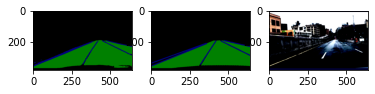

In [27]:
# Test the pretrained model loss on BDD100K
modelWithLoss = ModelWithLoss(model_pretrained)
with torch.no_grad():
    for data in tqdm(bdd_train_loader):
        seg_annot = data['segmentation'].to(device)
        cls_loss, reg_loss, seg_loss, regression, classification, anchors, segmentation = modelWithLoss(
            data['img'].to(device), data['annot'].to(device), seg_annot, obj_list=params.obj_list)
        break

fig, ax = plt.subplots(1, 3)
ax[0].imshow(colorfill_segmentation(segmentation[0].argmax(0)))
ax[1].imshow(colorfill_segmentation(seg_annot[0]))
ax[2].imshow(data['img'][0].permute(1, 2, 0))
print(seg_loss.cpu().numpy())

In [29]:
# Test the pretrained model on BDD100K
tn_l = []
fp_l = []
fn_l = []
tp_l = []
with torch.no_grad():
    for data in tqdm(bdd_test_loader):
        seg_annot = data['segmentation'].to(device)
        features, regression, classification, anchors, segmentation = model_pretrained(data['img'].to(device))
        tn, fp, fn, tp = confusionMatrix(segmentation.argmax(1), seg_annot)

        tn_l.extend(tn.cpu().tolist())
        fp_l.extend(fp.cpu().tolist())
        fn_l.extend(fn.cpu().tolist())
        tp_l.extend(tp.cpu().tolist())

100%|██████████| 625/625 [07:44<00:00,  1.35it/s]


In [30]:
tn_s = np.array(tn_l).sum()
fp_s = np.array(fp_l).sum()
fn_s = np.array(fn_l).sum()
tp_s = np.array(tp_l).sum()
cfn = np.array([[tn_s, fp_s], [fn_s, tp_s]])
cfn = cfn / cfn.sum()
pprint(cfn)
iou(tn_s, fp_s, fn_s, tp_s)
#sns.heatmap(cfn, annot=True)

array([[9.89549033e-01, 5.33379924e-04],
       [9.58723882e-04, 8.95886274e-03]])


0.8572281521077157

In [31]:
# Load the cityscapes dataset
cs_train_dataset = Cityscapes("datasets/", split="train", target_type="instance", transform=dataset_transforms, target_transform=transforms.ToTensor())
cs_val_dataset = Cityscapes("datasets/", split="val", target_type="instance", transform=dataset_transforms, target_transform=transforms.ToTensor())
cs_train_loader = DataLoader(cs_train_dataset, batch_size=8, shuffle=True, num_workers=2)
cs_val_loader = DataLoader(cs_val_dataset, batch_size=2, shuffle=True, num_workers=2)

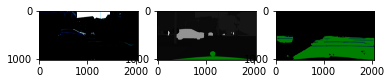

In [33]:
# view the Cityscapes dataset
# Road - id 7
# Sidewalk - id 8
img, seg = cs_train_dataset[0]
fig, ax = plt.subplots(1, 3)
img_gpu = img.unsqueeze(0).to(device)
with torch.no_grad():
    features, regression, classification, anchors, segmentation = model_pretrained(img_gpu)

ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(colorfill_segmentation(seg.squeeze(0)))
ax[2].imshow(colorfill_segmentation(segmentation[0].argmax(0)))

In [35]:
# Evaluate the pretrained model on Cityscapes
tn_l = []
fp_l = []
fnrd_l = []
tprd_l = []
fnsw_l = []
tpsw_l = []
with torch.no_grad():
    for img, seg in tqdm(cs_val_loader):
        seg_annot = seg.squeeze(1).to(device)
        features, regression, classification, anchors, segmentation = model_pretrained(img.to(device))
        tn, fp, fnrd, tprd, fnsw, tpsw = confusionMatrixCityscapes(segmentation.argmax(1), seg_annot)

        tn_l.extend(tn.cpu().tolist())
        fp_l.extend(fp.cpu().tolist())
        fnrd_l.extend(fnrd.cpu().tolist())
        tprd_l.extend(tprd.cpu().tolist())
        fnsw_l.extend(fnsw.cpu().tolist())
        tpsw_l.extend(tpsw.cpu().tolist())

100%|██████████| 250/250 [01:55<00:00,  2.16it/s]


In [36]:
tn_s = np.array(tn_l).sum()
fp_s = np.array(fp_l).sum()
fnrd_s = np.array(fnrd_l).sum()
tprd_s = np.array(tprd_l).sum()
fnsw_s = np.array(fnsw_l).sum()
tpsw_s = np.array(tpsw_l).sum()
cfn = np.array([[tn_s, fp_s], [fnrd_s, tprd_s], [fnsw_s, tpsw_s]])
pprint(cfn)
print(iouCityscapes(tn_s, fp_s, fnrd_s, tprd_s, fnsw_s, tpsw_s))
print(f"Recall of road detection (true positive rate): {tprd_s/(tprd_s + fnrd_s)}")
print(f"Recall of sidewalk detection (true positive rate): {tpsw_s/(tpsw_s + fnsw_s)}")

array([[1698185269,    4133637],
       [ 239773194,  105491248],
       [  48817372,     751280]])
0.2662942038643317
Recall of road detection (true positive rate): 0.3055375392523045
Recall of sidewalk detection (true positive rate): 0.01515635325326176


In [ ]:
# Train our model on Cityscapes!
epochs = 25
val_interval = 1
total_loss = []
optimizer = torch.optim.AdamW(model.parameters())

for epoch in range(epochs):
    epoch_loss = []
    if epoch % val_interval == 0:
        evaluateAndSaveCityscapes(model, epoch, total_loss)
    # train one epoch
    model.train()
    for img, seg in tqdm(cs_train_loader):
        optimizer.zero_grad()
        seg = seg.squeeze(1).to(device)
        seg = torch.where(torch.logical_or(seg == 7, seg == 8), 1, 0)
        cls_loss, reg_loss, seg_loss, regression, classification, anchors, segmentation = model(img.to(device), torch.zeros((16, 1, 5)).to(device), seg)
        loss = seg_loss.nanmean()
        loss.backward()
        optimizer.step()
        epoch_loss.append(float(loss))
    total_loss.append(sum(epoch_loss)/len(epoch_loss))
    print(torch.cuda.memory_summary())
    print(f"Epoch {epoch} loss: {total_loss[-1]}")
evaluateAndSaveCityscapes(model, 200, total_loss)

100%|██████████| 250/250 [01:32<00:00,  2.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice


Test Loss: nan
array([[1064937489,  637381417],
       [  59727005,  285537437],
       [   4727018,   44841634]])
Recall of road detection (true positive rate): 0.8270108423154678
Recall of sidewalk detection (true positive rate): 0.9046369467541704
IoU: 0.32006822950002106


100%|██████████| 372/372 [09:31<00:00,  1.54s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350451 KB |    8630 MB |   57579 GB |   57579 GB |
|       from large pool |  283130 KB |    8564 MB |   57444 GB |   57443 GB |
|       from small pool |   67321 KB |      83 MB |     135 GB |     135 GB |
|---------------------------------------------------------------------------|
| Active memory         |  350451 KB |    8630 MB |   57579 GB |   57579 GB |
|       from large pool |  283130 KB |    8564 MB |   57444 GB |

100%|██████████| 250/250 [01:32<00:00,  2.70it/s]


Test Loss: inf
array([[1678838594,   23480312],
       [  12952526,  332311916],
       [  15742621,   33826031]])
Recall of road detection (true positive rate): 0.9624852014155573
Recall of sidewalk detection (true positive rate): 0.6824077241398455
IoU: 0.8752718458179177


100%|██████████| 372/372 [09:30<00:00,  1.53s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350451 KB |    8885 MB |  115157 GB |  115157 GB |
|       from large pool |  283130 KB |    8819 MB |  114886 GB |  114886 GB |
|       from small pool |   67321 KB |      83 MB |     271 GB |     271 GB |
|---------------------------------------------------------------------------|
| Active memory         |  350451 KB |    8885 MB |  115157 GB |  115157 GB |
|       from large pool |  283130 KB |    8819 MB |  114886 GB |

100%|██████████| 250/250 [01:32<00:00,  2.70it/s]


Test Loss: inf
array([[1680180532,   22138374],
       [  13391213,  331873229],
       [  14850045,   34718607]])
Recall of road detection (true positive rate): 0.9612146187935565
Recall of sidewalk detection (true positive rate): 0.7004145886396104
IoU: 0.8791772678316685


100%|██████████| 372/372 [09:23<00:00,  1.51s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350409 KB |    8886 MB |  172735 GB |  172734 GB |
|       from large pool |  283088 KB |    8820 MB |  172328 GB |  172327 GB |
|       from small pool |   67321 KB |      85 MB |     406 GB |     406 GB |
|---------------------------------------------------------------------------|
| Active memory         |  350409 KB |    8886 MB |  172735 GB |  172734 GB |
|       from large pool |  283088 KB |    8820 MB |  172328 GB |

100%|██████████| 250/250 [01:32<00:00,  2.69it/s]


Test Loss: inf
array([[1678735952,   23582954],
       [  10535734,  334728708],
       [  10311203,   39257449]])
Recall of road detection (true positive rate): 0.9694850302597914
Recall of sidewalk detection (true positive rate): 0.7919813716136561
IoU: 0.893814084779081


100%|██████████| 372/372 [09:29<00:00,  1.53s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350451 KB |    8886 MB |  230312 GB |  230312 GB |
|       from large pool |  283130 KB |    8820 MB |  229770 GB |  229770 GB |
|       from small pool |   67321 KB |      85 MB |     542 GB |     542 GB |
|---------------------------------------------------------------------------|
| Active memory         |  350451 KB |    8886 MB |  230312 GB |  230312 GB |
|       from large pool |  283130 KB |    8820 MB |  229770 GB |

100%|██████████| 250/250 [01:34<00:00,  2.66it/s]


Test Loss: inf
array([[1683959467,   18359439],
       [  14724222,  330540220],
       [  16277663,   33290989]])
Recall of road detection (true positive rate): 0.9573537839149969
Recall of sidewalk detection (true positive rate): 0.6716137650868537
IoU: 0.8805367472601447


100%|██████████| 372/372 [09:32<00:00,  1.54s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350409 KB |    9525 MB |  287886 GB |  287886 GB |
|       from large pool |  283088 KB |    9459 MB |  287208 GB |  287208 GB |
|       from small pool |   67321 KB |      85 MB |     678 GB |     678 GB |
|---------------------------------------------------------------------------|
| Active memory         |  350409 KB |    9525 MB |  287886 GB |  287886 GB |
|       from large pool |  283088 KB |    9459 MB |  287208 GB |

100%|██████████| 250/250 [01:38<00:00,  2.54it/s]


Test Loss: inf
array([[1684781587,   17537319],
       [  14960656,  330303786],
       [  13357199,   36211453]])
Recall of road detection (true positive rate): 0.9566689928643158
Recall of sidewalk detection (true positive rate): 0.7305313245153409
IoU: 0.8888010086213436


100%|██████████| 372/372 [09:38<00:00,  1.56s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350409 KB |    9525 MB |  345465 GB |  345465 GB |
|       from large pool |  283088 KB |    9459 MB |  344652 GB |  344651 GB |
|       from small pool |   67321 KB |      85 MB |     813 GB |     813 GB |
|---------------------------------------------------------------------------|
| Active memory         |  350409 KB |    9525 MB |  345465 GB |  345465 GB |
|       from large pool |  283088 KB |    9459 MB |  344652 GB |

100%|██████████| 250/250 [01:34<00:00,  2.65it/s]


Test Loss: inf
array([[1678224381,   24094525],
       [   8294264,  336970178],
       [   8848560,   40720092]])
Recall of road detection (true positive rate): 0.9759770686145549
Recall of sidewalk detection (true positive rate): 0.8214887909398868
IoU: 0.901564501527888


100%|██████████| 372/372 [09:42<00:00,  1.57s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350409 KB |    9525 MB |  403047 GB |  403047 GB |
|       from large pool |  283088 KB |    9459 MB |  402098 GB |  402097 GB |
|       from small pool |   67321 KB |      85 MB |     949 GB |     949 GB |
|---------------------------------------------------------------------------|
| Active memory         |  350409 KB |    9525 MB |  403047 GB |  403047 GB |
|       from large pool |  283088 KB |    9459 MB |  402098 GB |

100%|██████████| 250/250 [01:33<00:00,  2.68it/s]


Test Loss: inf
array([[1682746372,   19572534],
       [  11086914,  334177528],
       [  13528483,   36040169]])
Recall of road detection (true positive rate): 0.9678886307093274
Recall of sidewalk detection (true positive rate): 0.7270758341380759
IoU: 0.8933703405205684


100%|██████████| 372/372 [09:17<00:00,  1.50s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350409 KB |    9525 MB |  460628 GB |  460627 GB |
|       from large pool |  283088 KB |    9459 MB |  459543 GB |  459543 GB |
|       from small pool |   67321 KB |      85 MB |    1084 GB |    1084 GB |
|---------------------------------------------------------------------------|
| Active memory         |  350409 KB |    9525 MB |  460628 GB |  460627 GB |
|       from large pool |  283088 KB |    9459 MB |  459543 GB |

100%|██████████| 250/250 [01:31<00:00,  2.75it/s]


Test Loss: inf
array([[1682072440,   20246466],
       [  13274025,  331990417],
       [  10351936,   39216716]])
Recall of road detection (true positive rate): 0.9615540339946156
Recall of sidewalk detection (true positive rate): 0.7911596224161996
IoU: 0.8943035715851679


100%|██████████| 372/372 [09:15<00:00,  1.49s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350451 KB |    9525 MB |  518209 GB |  518208 GB |
|       from large pool |  283130 KB |    9459 MB |  516988 GB |  516988 GB |
|       from small pool |   67321 KB |      85 MB |    1220 GB |    1220 GB |
|---------------------------------------------------------------------------|
| Active memory         |  350451 KB |    9525 MB |  518209 GB |  518208 GB |
|       from large pool |  283130 KB |    9459 MB |  516988 GB |

100%|██████████| 250/250 [01:32<00:00,  2.72it/s]


Test Loss: inf
array([[1678909431,   23409475],
       [  10310705,  334953737],
       [   9163360,   40405292]])
Recall of road detection (true positive rate): 0.9701367886589376
Recall of sidewalk detection (true positive rate): 0.8151380029458941
IoU: 0.8974672996521308


100%|██████████| 372/372 [09:14<00:00,  1.49s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350409 KB |    9525 MB |  575786 GB |  575786 GB |
|       from large pool |  283088 KB |    9459 MB |  574430 GB |  574430 GB |
|       from small pool |   67321 KB |      85 MB |    1356 GB |    1356 GB |
|---------------------------------------------------------------------------|
| Active memory         |  350409 KB |    9525 MB |  575786 GB |  575786 GB |
|       from large pool |  283088 KB |    9459 MB |  574430 GB |

100%|██████████| 250/250 [01:30<00:00,  2.76it/s]


Test Loss: inf
array([[1683307573,   19011333],
       [  11098107,  334166335],
       [  12823207,   36745445]])
Recall of road detection (true positive rate): 0.967856212079899
Recall of sidewalk detection (true positive rate): 0.7413041008256589
IoU: 0.8962589702820862


100%|██████████| 372/372 [09:17<00:00,  1.50s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350451 KB |    9525 MB |  633368 GB |  633368 GB |
|       from large pool |  283130 KB |    9459 MB |  631876 GB |  631876 GB |
|       from small pool |   67321 KB |      85 MB |    1491 GB |    1491 GB |
|---------------------------------------------------------------------------|
| Active memory         |  350451 KB |    9525 MB |  633368 GB |  633368 GB |
|       from large pool |  283130 KB |    9459 MB |  631876 GB |

100%|██████████| 250/250 [01:32<00:00,  2.69it/s]


Test Loss: inf
array([[1680713389,   21605517],
       [  12286023,  332978419],
       [   7677753,   41890899]])
Recall of road detection (true positive rate): 0.9644156145103411
Recall of sidewalk detection (true positive rate): 0.8451086989414197
IoU: 0.9001790614463461


100%|██████████| 372/372 [09:15<00:00,  1.49s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350409 KB |   10805 MB |  690946 GB |  690946 GB |
|       from large pool |  283088 KB |   10739 MB |  689319 GB |  689319 GB |
|       from small pool |   67321 KB |      85 MB |    1627 GB |    1627 GB |
|---------------------------------------------------------------------------|
| Active memory         |  350409 KB |   10805 MB |  690946 GB |  690946 GB |
|       from large pool |  283088 KB |   10739 MB |  689319 GB |

100%|██████████| 250/250 [01:30<00:00,  2.75it/s]


Test Loss: inf
array([[1686199575,   16119331],
       [  14458615,  330805827],
       [  20403130,   29165522]])
Recall of road detection (true positive rate): 0.9581230696209371
Recall of sidewalk detection (true positive rate): 0.5883864261630516
IoU: 0.8759440925552392


100%|██████████| 372/372 [09:14<00:00,  1.49s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350409 KB |   10805 MB |  748524 GB |  748523 GB |
|       from large pool |  283088 KB |   10739 MB |  746761 GB |  746760 GB |
|       from small pool |   67321 KB |      85 MB |    1763 GB |    1762 GB |
|---------------------------------------------------------------------------|
| Active memory         |  350409 KB |   10805 MB |  748524 GB |  748523 GB |
|       from large pool |  283088 KB |   10739 MB |  746761 GB |

100%|██████████| 250/250 [01:34<00:00,  2.64it/s]


Test Loss: inf
array([[1688293989,   14024917],
       [  20083540,  325180902],
       [  16072210,   33496442]])
Recall of road detection (true positive rate): 0.9418314267068371
Recall of sidewalk detection (true positive rate): 0.6757585822588034
IoU: 0.8772662742323031


100%|██████████| 372/372 [09:15<00:00,  1.49s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350409 KB |   10805 MB |     787 TB |     787 TB |
|       from large pool |  283088 KB |   10739 MB |     785 TB |     785 TB |
|       from small pool |   67321 KB |      85 MB |       1 TB |       1 TB |
|---------------------------------------------------------------------------|
| Active memory         |  350409 KB |   10805 MB |     787 TB |     787 TB |
|       from large pool |  283088 KB |   10739 MB |     785 TB |

100%|██████████| 250/250 [01:30<00:00,  2.78it/s]


Test Loss: inf
array([[1680953307,   21365599],
       [  10951941,  334312501],
       [   7249806,   42318846]])
Recall of road detection (true positive rate): 0.9682795571517324
Recall of sidewalk detection (true positive rate): 0.8537421191118936
IoU: 0.9049315947755752


100%|██████████| 372/372 [09:17<00:00,  1.50s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350409 KB |   10805 MB |     843 TB |     843 TB |
|       from large pool |  283088 KB |   10739 MB |     841 TB |     841 TB |
|       from small pool |   67321 KB |      85 MB |       1 TB |       1 TB |
|---------------------------------------------------------------------------|
| Active memory         |  350409 KB |   10805 MB |     843 TB |     843 TB |
|       from large pool |  283088 KB |   10739 MB |     841 TB |

100%|██████████| 250/250 [01:32<00:00,  2.70it/s]


Test Loss: inf
array([[1688737390,   13581516],
       [  22494582,  322769860],
       [  12622521,   36946131]])
Recall of road detection (true positive rate): 0.9348482517640783
Recall of sidewalk detection (true positive rate): 0.7453527483458698
IoU: 0.8807618096717941


100%|██████████| 372/372 [09:15<00:00,  1.49s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350451 KB |   10805 MB |     899 TB |     899 TB |
|       from large pool |  283130 KB |   10739 MB |     897 TB |     897 TB |
|       from small pool |   67321 KB |      85 MB |       2 TB |       2 TB |
|---------------------------------------------------------------------------|
| Active memory         |  350451 KB |   10805 MB |     899 TB |     899 TB |
|       from large pool |  283130 KB |   10739 MB |     897 TB |

100%|██████████| 250/250 [01:30<00:00,  2.76it/s]


Test Loss: inf
array([[1683008385,   19310521],
       [  11846709,  333417733],
       [  11863055,   37705597]])
Recall of road detection (true positive rate): 0.9656880131316853
Recall of sidewalk detection (true positive rate): 0.7606742462958243
IoU: 0.8961223028876106


100%|██████████| 372/372 [09:14<00:00,  1.49s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350409 KB |   10805 MB |     955 TB |     955 TB |
|       from large pool |  283088 KB |   10739 MB |     953 TB |     953 TB |
|       from small pool |   67321 KB |      85 MB |       2 TB |       2 TB |
|---------------------------------------------------------------------------|
| Active memory         |  350409 KB |   10805 MB |     955 TB |     955 TB |
|       from large pool |  283088 KB |   10739 MB |     953 TB |

100%|██████████| 250/250 [01:31<00:00,  2.73it/s]


Test Loss: inf
array([[1684905726,   17413180],
       [  12331898,  332932544],
       [  14181212,   35387440]])
Recall of road detection (true positive rate): 0.9642827453398749
Recall of sidewalk detection (true positive rate): 0.7139076527640897
IoU: 0.8934464838850187


100%|██████████| 372/372 [09:15<00:00,  1.49s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350409 KB |   10805 MB |    1012 TB |    1012 TB |
|       from large pool |  283088 KB |   10739 MB |    1009 TB |    1009 TB |
|       from small pool |   67321 KB |      85 MB |       2 TB |       2 TB |
|---------------------------------------------------------------------------|
| Active memory         |  350409 KB |   10805 MB |    1012 TB |    1012 TB |
|       from large pool |  283088 KB |   10739 MB |    1009 TB |

100%|██████████| 250/250 [01:32<00:00,  2.72it/s]


Test Loss: inf
array([[1683990614,   18328292],
       [  11864366,  333400076],
       [  13447479,   36121173]])
Recall of road detection (true positive rate): 0.965636872620668
Recall of sidewalk detection (true positive rate): 0.7287100121262123
IoU: 0.8943750832513666


100%|██████████| 372/372 [09:13<00:00,  1.49s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350409 KB |   10805 MB |    1068 TB |    1068 TB |
|       from large pool |  283088 KB |   10739 MB |    1065 TB |    1065 TB |
|       from small pool |   67321 KB |      85 MB |       2 TB |       2 TB |
|---------------------------------------------------------------------------|
| Active memory         |  350409 KB |   10805 MB |    1068 TB |    1068 TB |
|       from large pool |  283088 KB |   10739 MB |    1065 TB |

100%|██████████| 250/250 [01:32<00:00,  2.72it/s]


Test Loss: inf
array([[1683637995,   18680911],
       [  12133000,  333131442],
       [  13958491,   35610161]])
Recall of road detection (true positive rate): 0.964858819721725
Recall of sidewalk detection (true positive rate): 0.7184008352698394
IoU: 0.8917269996695759


100%|██████████| 372/372 [09:15<00:00,  1.49s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350409 KB |   10805 MB |    1124 TB |    1124 TB |
|       from large pool |  283088 KB |   10739 MB |    1121 TB |    1121 TB |
|       from small pool |   67321 KB |      85 MB |       2 TB |       2 TB |
|---------------------------------------------------------------------------|
| Active memory         |  350409 KB |   10805 MB |    1124 TB |    1124 TB |
|       from large pool |  283088 KB |   10739 MB |    1121 TB |

100%|██████████| 250/250 [01:32<00:00,  2.69it/s]


Test Loss: inf
array([[1687019416,   15299490],
       [  15744215,  329520227],
       [  15757811,   33810841]])
Recall of road detection (true positive rate): 0.9543995468841242
Recall of sidewalk detection (true positive rate): 0.6821012804624987
IoU: 0.8858868623810685


100%|██████████| 372/372 [09:12<00:00,  1.48s/it]


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  350409 KB |   10805 MB |    1180 TB |    1180 TB |
|       from large pool |  283088 KB |   10739 MB |    1178 TB |    1178 TB |
|       from small pool |   67321 KB |      85 MB |       2 TB |       2 TB |
|---------------------------------------------------------------------------|
| Active memory         |  350409 KB |   10805 MB |    1180 TB |    1180 TB |
|       from large pool |  283088 KB |   10739 MB |    1178 TB |

100%|██████████| 250/250 [01:32<00:00,  2.71it/s]


Test Loss: inf
array([[1682510688,   19808218],
       [  11527174,  333737268],
       [   9968329,   39600323]])
Recall of road detection (true positive rate): 0.9666134921591492
Recall of sidewalk detection (true positive rate): 0.7988985256246226
IoU: 0.9003868649730685


  5%|▌         | 20/372 [00:33<09:47,  1.67s/it]


KeyboardInterrupt: ignored

In [ ]:
# These next two cells are extracting parameters from our models saved on Google drive
path = Path("drive/MyDrive/Thesis/models/hybridnet")
models = [torch.load(path / fn, map_location=device) for fn in os.listdir(path)]
items = ['epoch', 'train_loss', 'iou', 'rd_recall', 'sw_recall']
train_curve_data = {i: [m[i] for m in models] for i in items}
train_curve_data['train_loss'] = train_curve_data['train_loss'][-1]
train_curve_data['train_loss'] = [train_curve_data['train_loss'][0], *train_curve_data['train_loss']]
train_curve_data['iou'][0] = 0.266
train_curve_data['rd_recall'][0] = 0.306
train_curve_data['sw_recall'][0] = 0.015

       train_loss       iou  rd_recall  sw_recall
epoch                                            
0        0.124489  0.266000   0.306000   0.015000
1        0.124489  0.875272   0.962485   0.682408
2        0.068477  0.879177   0.961215   0.700415
3        0.062927  0.893814   0.969485   0.791981
4        0.057418  0.880537   0.957354   0.671614


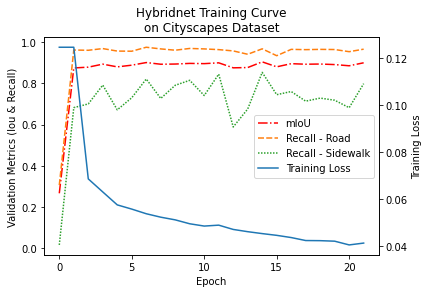

In [ ]:
# We can now generate a training curve from our saved models
train_curve_pd = pd.DataFrame(train_curve_data).set_index('epoch')
print(train_curve_pd.head())

fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=train_curve_pd.drop('train_loss', axis='columns'), ax=ax)
ax.set(xlabel='Epoch',
       ylabel='Validation Metrics (Iou & Recall)',
       title="Hybridnet Training Curve\non Cityscapes Dataset")
ax.lines[0].set_linestyle("-.")
ax.lines[0].set_color("red")

axLoss = ax.twinx()
train_curve_pd.plot(y="train_loss", ax=axLoss, legend=False)
axLoss.set(ylabel='Training Loss')

ax.legend(['mIoU', 'Recall - Road', 'Recall - Sidewalk', 'Training Loss'], loc=7)

fig.savefig('drive/MyDrive/Thesis/figures/hybridnet_training_curve.png', dpi=600)
fig.show()